<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_100_acc(y_true, y_pred):
    delta = 100
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_300_acc(y_true, y_pred):
    delta = 300
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 5.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=1c4e49a6ce3e3cfde8fe7fb14cc1efd901b544ad28f37b927ff3b6db71f96126
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate

In [3]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [4]:
dataset = create_samples(n_samples=1000)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,280176,0.48,134484.48
1,1000,354594,0.48,170205.12
2,1000,129724,0.48,62267.52
3,1000,172780,0.48,82934.40
4,1000,181220,0.48,86985.60
...,...,...,...,...
132644,1519,60840,0.55,33462.00
132645,1519,71706,0.55,39438.30
132646,1519,406,0.55,223.30
132647,1519,49200,0.55,27060.00


In [5]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max
CODE,int64,132649.0,0,1254.882479,152.590942,1000.00,1120.00,1250.00,1389.00,1519.00
REAL_YY,int64,132649.0,0,250293.627558,220594.652267,1.00,68720.00,186238.00,382104.00,993006.00
COM_RATE,float64,132649.0,0,0.517639,0.288179,0.01,0.28,0.52,0.77,0.99
NAFYC,float64,132649.0,0,129249.740946,149219.335575,0.64,21786.05,72714.60,183934.52,954656.01


In [6]:
dataset = dataset.astype({"CODE": object})

In [7]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,132649.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1134.0,497.0
REAL_YY,int64,132649.0,0,250293.627558,220594.652267,1.00,68720.00,186238.00,382104.00,993006.00,NaN,NaN,NaN
COM_RATE,float64,132649.0,0,0.517639,0.288179,0.01,0.28,0.52,0.77,0.99,NaN,NaN,NaN
NAFYC,float64,132649.0,0,129249.740946,149219.335575,0.64,21786.05,72714.60,183934.52,954656.01,NaN,NaN,NaN


In [8]:
dataset[dataset['CODE'] == 1386]

,CODE,REAL_YY,COM_RATE,NAFYC
98867,1386,911,0.8,728.8
98868,1386,222000,0.8,177600.0
98869,1386,36897,0.8,29517.6
98870,1386,5840,0.8,4672.0
98871,1386,104413,0.8,83530.4
...,...,...,...,...
99283,1386,15540,0.8,12432.0
99284,1386,3335,0.8,2668.0
99285,1386,62418,0.8,49934.4
99286,1386,229866,0.8,183892.8


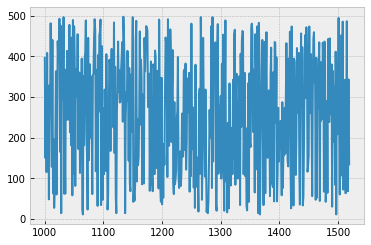

In [9]:
plt.plot(dataset.groupby('CODE')['CODE'].count())

In [10]:
# zscore norm

ds = dataset[['REAL_YY','COM_RATE']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,0.135463,-0.130609,134484.48
1,1000,0.472815,-0.130609,170205.12
2,1000,-0.546566,-0.130609,62267.52
3,1000,-0.351385,-0.130609,82934.40
4,1000,-0.313125,-0.130609,86985.60
...,...,...,...,...
132644,1519,-0.858831,0.112295,33462.00
132645,1519,-0.809574,0.112295,39438.30
132646,1519,-1.132791,0.112295,223.30
132647,1519,-0.911598,0.112295,27060.00


In [11]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [12]:
code_mapping = EmbeddingMapping(dataset['CODE'])
dataset = dataset.assign(code_mapping=dataset['CODE'].apply(code_mapping.get_mapping))
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,0.135463,-0.130609,134484.48,1
1,1000,0.472815,-0.130609,170205.12,1
2,1000,-0.546566,-0.130609,62267.52,1
3,1000,-0.351385,-0.130609,82934.40,1
4,1000,-0.313125,-0.130609,86985.60,1
...,...,...,...,...,...
132644,1519,-0.858831,0.112295,33462.00,520
132645,1519,-0.809574,0.112295,39438.30,520
132646,1519,-1.132791,0.112295,223.30,520
132647,1519,-0.911598,0.112295,27060.00,520


In [13]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY']]
X_val_categorical = X_val_org[['code_mapping']]


In [14]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

epochs = 500

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        33344       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64)           0           embedding[0][0]                  
_______________________

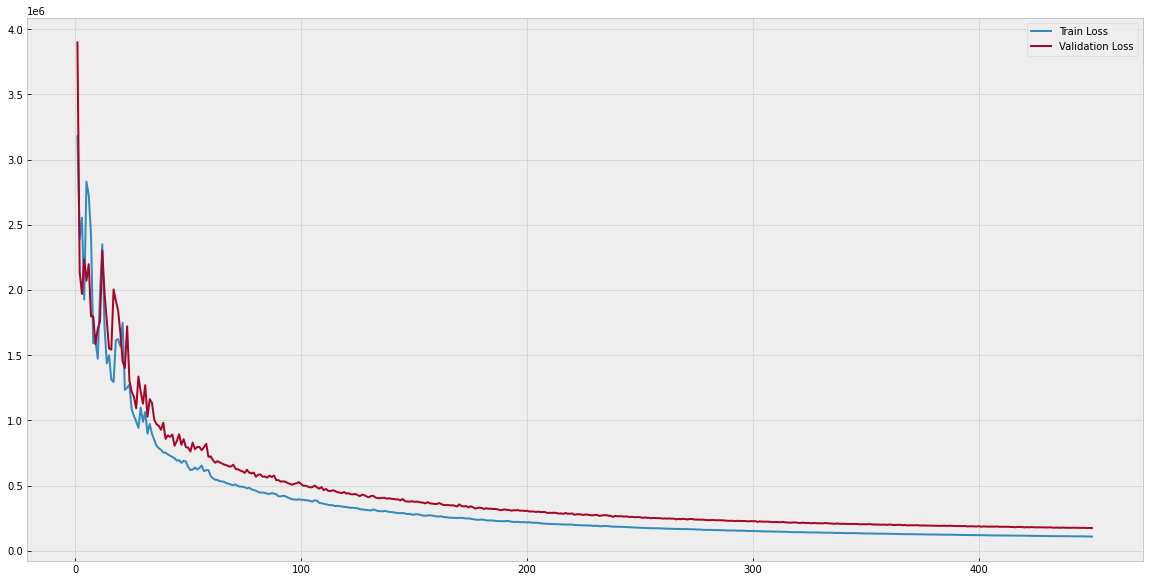

In [15]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][50:]
_val_loss = history.history['val_loss'][50:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 131287
The mean is very close to 0 (21.1) with std. 416.39.


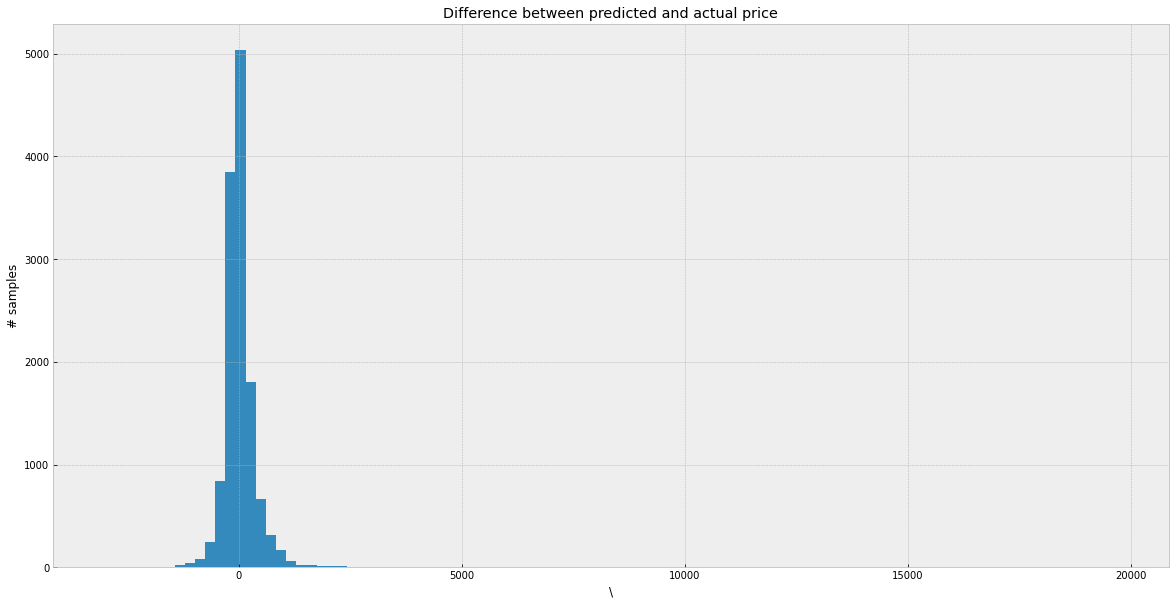

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
38423,536954.750000,19707.950000,19707.950000,3.810164,3.810164,1137,2.773342,0.285798,517246.80,138
51669,190182.562500,6403.162500,6403.162500,3.484157,3.484157,1187,3.250153,-1.136927,183779.40,188
99941,730943.812500,6366.412500,6366.412500,0.878638,0.878638,1391,2.729669,1.153314,724577.40,392
66176,354132.156250,6166.956250,6166.956250,1.772291,1.772291,1249,2.808859,-0.408214,347965.20,250
24655,710449.750000,5163.900000,5163.900000,0.732171,0.732171,1089,3.245098,0.736907,705285.85,90
28072,627926.312500,5089.832500,5089.832500,0.817202,0.817202,1102,3.276999,0.424601,622836.48,103
39799,356026.281250,4992.481250,4992.481250,1.422222,1.422222,1142,2.746605,-0.373513,351033.80,143
57336,133642.796875,4941.626875,4941.626875,3.839613,3.839613,1210,3.353279,-1.345131,128701.17,211
38760,501599.718750,4141.718750,4141.718750,0.832577,0.832577,1139,3.120231,0.042894,497458.00,140
75674,4923.627441,3999.627441,3999.627441,432.860113,432.860113,1292,-1.121938,-0.651118,924.00,293


In [16]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [17]:
dataset[dataset['code_mapping']==3]

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
546,1002,1.007052,-0.269411,207875.36,3
547,1002,0.054654,-0.269411,115434.00,3
548,1002,-0.701366,-0.269411,42053.44,3
549,1002,-0.398226,-0.269411,71476.68,3
550,1002,-0.032859,-0.269411,106939.80,3
...,...,...,...,...,...
840,1002,-0.235557,-0.269411,87265.64,3
841,1002,1.242697,-0.269411,230747.44,3
842,1002,-0.809587,-0.269411,31549.32,3
843,1002,0.356212,-0.269411,144703.68,3


In [18]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,0.135463,-0.130609,134484.48,1
1,1000,0.472815,-0.130609,170205.12,1
2,1000,-0.546566,-0.130609,62267.52,1
3,1000,-0.351385,-0.130609,82934.40,1
4,1000,-0.313125,-0.130609,86985.60,1
...,...,...,...,...,...
132644,1519,-0.858831,0.112295,33462.00,520
132645,1519,-0.809574,0.112295,39438.30,520
132646,1519,-1.132791,0.112295,223.30,520
132647,1519,-0.911598,0.112295,27060.00,520


In [19]:
dataset['ft1'] = dataset['REAL_YY']* dataset['COM_RATE']

In [20]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
0,1000,0.135463,-0.130609,134484.48,1,-0.017693
1,1000,0.472815,-0.130609,170205.12,1,-0.061754
2,1000,-0.546566,-0.130609,62267.52,1,0.071386
3,1000,-0.351385,-0.130609,82934.40,1,0.045894
4,1000,-0.313125,-0.130609,86985.60,1,0.040897
...,...,...,...,...,...,...
132644,1519,-0.858831,0.112295,33462.00,520,-0.096443
132645,1519,-0.809574,0.112295,39438.30,520,-0.090911
132646,1519,-1.132791,0.112295,223.30,520,-0.127207
132647,1519,-0.911598,0.112295,27060.00,520,-0.102368


In [21]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping']]


In [22]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

epochs = 500

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_1/concat:0", shape=(None, 66), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        33344       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 64)           0           embedding_1[0][0]                
_____________________

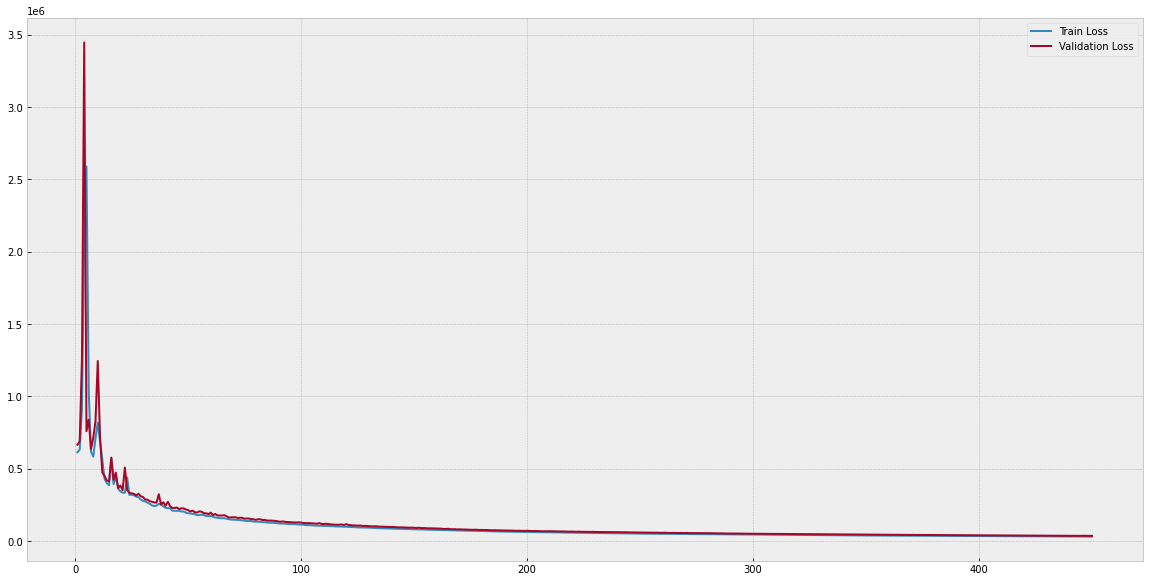

In [23]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][50:]
_val_loss = history.history['val_loss'][50:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

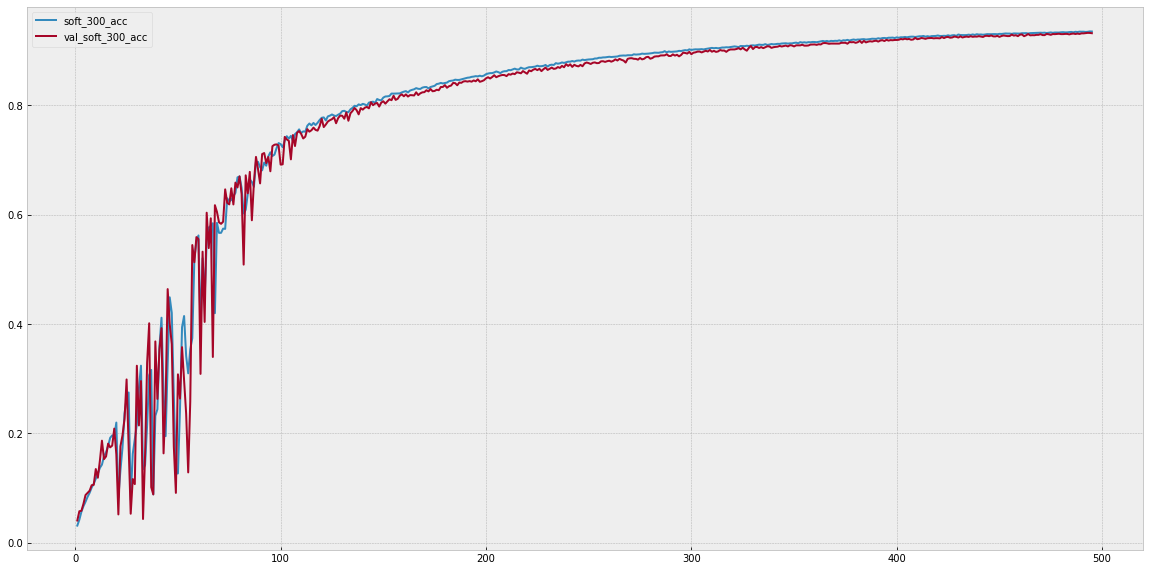

In [24]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_300_acc'][5:]
_val_loss = history.history['val_soft_300_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_300_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_300_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 131287
The mean is very close to 0 (7.76) with std. 191.22.


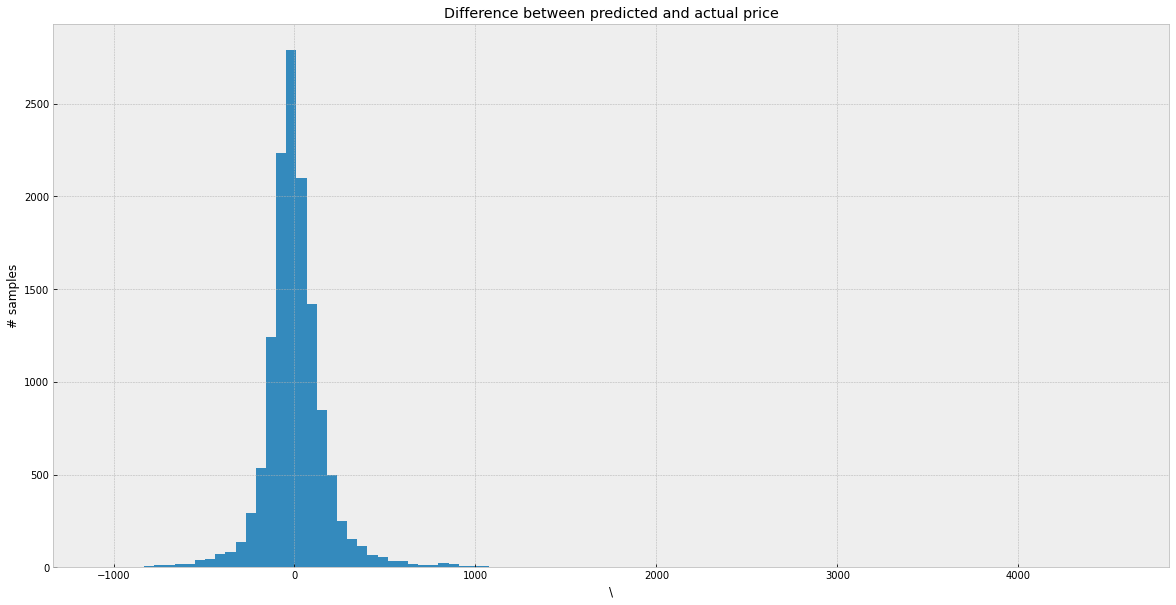

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
38423,521799.343750,4552.543750,4552.543750,0.880149,0.880149,1137,2.773342,0.285798,517246.80,138,0.792617
127388,397759.625000,2642.105000,2642.105000,0.668688,0.668688,1498,3.130005,-0.338813,395117.52,499,-1.060486
75674,3406.056152,2482.056152,2482.056152,268.620796,268.620796,1292,-1.121938,-0.651118,924.00,293,0.730515
52497,11018.626953,2369.266953,2369.266953,27.392396,27.392396,1189,2.786298,-1.761538,8649.36,190,-4.908170
52474,10877.864258,2279.504258,2279.504258,26.510919,26.510919,1189,2.763178,-1.761538,8598.36,190,-4.867444
131452,10796.859375,2273.099375,2273.099375,26.667801,26.667801,1514,2.729361,-1.761538,8523.76,515,-4.807873
127412,374770.062500,2062.062500,2062.062500,0.553265,0.553265,1498,2.888132,-0.338813,372708.00,499,-0.978536
17680,4631.476074,1990.276074,1990.276074,75.354993,75.354993,1065,-1.121757,1.430919,2641.20,66,-1.605144
21926,2781.251221,1892.951221,1892.951221,213.098190,213.098190,1081,-1.130348,1.465620,888.30,82,-1.656660
1896,1865.211182,1693.311182,1693.311182,985.055952,985.055952,1008,-1.132900,-0.234711,171.90,9,0.265904


In [25]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [26]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['NAFYC'],
    mode="regression"
)

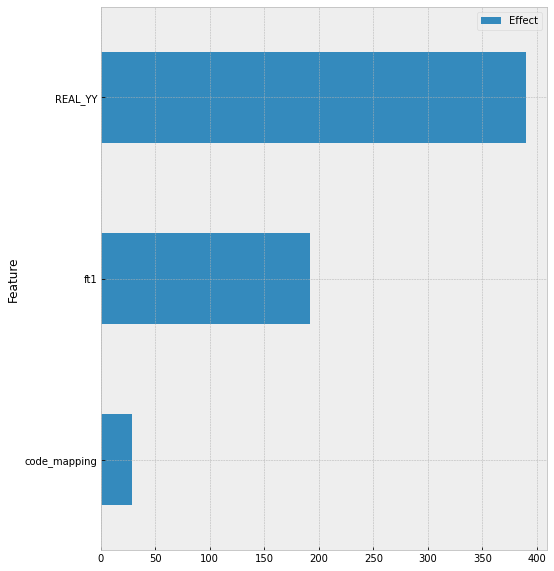

,Feature,Effect
0,code_mapping,28.629659
1,ft1,191.717654
2,REAL_YY,389.752882


In [27]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 10),kind='barh')
plt.show()
effect_result_table

## 시뮬레이션 데이터 생성

In [28]:
contract_change_rules = {
    '성립': 0,
    '실효': -0.4,
    '해약': -0.8,
    '철회': -0.5,
    '변경': -0.1
}

def create_samples2():
    rate_table = {}
    samples = []
    start_date = datetime.date(2015, 1, 1)
    end_date = datetime.date(2020, 8, 8)

    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,250))
      for j in range(count):
        cntr_no = str(random.choice(range(100000,500000))) + ':' + str(random.choice(range(100000,500000)))
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]

        div = '성립'
        minus_rate = 0

        # 계약일 생성
        time_between_dates = end_date - start_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        contract_date = start_date + datetime.timedelta(days=random_number_of_days)
        event_date = contract_date
        # 계약 총개월수 생성 
        contract_months = np.random.choice(range(12,12*30))

        samples.append([cntr_no,div,minus_rate,contract_date,contract_months,event_date,code,real_yy,rate])
        for changes in range(20):
          div = random.choice(['실효','해약','철회','변경'])
          # Event 발생일 생성 
          time_between_dates = end_date - event_date
          days_between_dates = time_between_dates.days
          random_number_of_days = random.randrange(days_between_dates)
          event_date = event_date + datetime.timedelta(days=random_number_of_days)
          if div=='변경':
            contract_date = event_date
            code = np.random.choice(range(1000,1520))
            real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
            contract_months = np.random.choice(range(12,12*30))       
            if code not in rate_table:
              rate = np.random.choice(range(1,100)) / 100
              rate_table[code] = rate
            else:
              rate = rate_table[code]
          elif div=='해약':
            samples.append([cntr_no,div,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
            break

          samples.append([cntr_no,div,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CONTRACT_ID','DIV','MINUS_RATE','CONTRACT_DATE','CONTRACT_MONTHS','EVENT_DATE','CODE','REAL_YY','COM_RATE'])

In [29]:
dataset2 = create_samples2()

In [30]:
dataset2.head(10)


,CONTRACT_ID,DIV,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE
0,411376:339373,성립,0.0,2020-03-15,32,2020-03-15,1000,16732,0.01
1,411376:339373,실효,-0.4,2020-03-15,32,2020-07-07,1000,16732,0.01
2,411376:339373,해약,-0.8,2020-03-15,32,2020-07-08,1000,16732,0.01
3,189243:237101,성립,0.0,2015-11-01,22,2015-11-01,1000,21643,0.01
4,189243:237101,실효,-0.4,2015-11-01,22,2016-04-26,1000,21643,0.01
5,189243:237101,철회,-0.5,2015-11-01,22,2017-05-28,1000,21643,0.01
6,189243:237101,실효,-0.4,2015-11-01,22,2017-11-13,1000,21643,0.01
7,189243:237101,해약,-0.8,2015-11-01,22,2020-07-12,1000,21643,0.01
8,125528:436438,성립,0.0,2015-07-06,241,2015-07-06,1000,654360,0.01
9,125528:436438,해약,-0.8,2015-07-06,241,2018-10-12,1000,654360,0.01


In [31]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [32]:
back_nafyc = {}

def nafyc_func2(row):
  CONTRACT_ID = row['CONTRACT_ID']
  DIV = row['DIV']
  MINUS_RATE = row['MINUS_RATE']
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  CODE = row['CODE']
  REAL_YY = row['REAL_YY']
  COM_RATE = row['COM_RATE']
  if DIV=='성립':
    nafyc = REAL_YY * COM_RATE
    back_nafyc[CONTRACT_ID] = nafyc
  else:
    nafyc = back_nafyc[CONTRACT_ID]
    # event가 발생하면 nafyc = nafyc + nafyc * (남은기간/전체기간 * 마이너스비율)
    nafyc = nafyc + nafyc * MINUS_RATE * ((CONTRACT_MONTHS - diff_month(EVENT_DATE,CONTRACT_DATE))/CONTRACT_MONTHS)
    back_nafyc[CONTRACT_ID] = nafyc

  return nafyc

In [33]:
dataset2['NAFYC'] = dataset2.apply(nafyc_func2, axis=1)

In [34]:
dataset2

,CONTRACT_ID,DIV,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC
0,411376:339373,성립,0.0,2020-03-15,32,2020-03-15,1000,16732,0.01,167.320000
1,411376:339373,실효,-0.4,2020-03-15,32,2020-07-07,1000,16732,0.01,108.758000
2,411376:339373,해약,-0.8,2020-03-15,32,2020-07-08,1000,16732,0.01,32.627400
3,189243:237101,성립,0.0,2015-11-01,22,2015-11-01,1000,21643,0.01,216.430000
4,189243:237101,실효,-0.4,2015-11-01,22,2016-04-26,1000,21643,0.01,149.533455
...,...,...,...,...,...,...,...,...,...,...
326363,383225:216540,변경,-0.1,2020-07-01,126,2020-07-01,1048,30240,0.48,30863.738628
326364,383225:216540,해약,-0.8,2020-07-01,126,2020-07-26,1048,30240,0.48,6172.747726
326365,340898:122470,성립,0.0,2018-02-02,62,2018-02-02,1048,369199,0.48,177215.520000
326366,340898:122470,철회,-0.5,2018-02-02,62,2019-10-06,1048,369199,0.48,117190.908387


## EDA 과정

In [35]:
dataset2.groupby('CONTRACT_ID').count().max()

DIV                21
MINUS_RATE         21
CONTRACT_DATE      21
CONTRACT_MONTHS    21
EVENT_DATE         21
CODE               21
REAL_YY            21
COM_RATE           21
NAFYC              21
dtype: int64

## 데이터 전처리...

In [36]:
dataset2 = dataset2.astype({"CODE": object})

In [37]:
structure(dataset2)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CONTRACT_ID,object,326368,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65223,279165:434186,21
DIV,object,326368,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,변경,65667
MINUS_RATE,float64,326368,0,-0.359306,0.286849,-0.8,-0.5,-0.4,-0.1,0,NaN,NaN,NaN
CONTRACT_DATE,object,326368,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,28943
CONTRACT_MONTHS,int64,326368,0,185.224,100.521,12,98,185,272,359,NaN,NaN,NaN
EVENT_DATE,object,326368,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,46988
CODE,object,326368,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520,1417,861
REAL_YY,int64,326368,0,250282,220099,4,68140.5,187596,381360,994008,NaN,NaN,NaN
COM_RATE,float64,326368,0,0.49788,0.286336,0.01,0.25,0.5,0.75,0.99,NaN,NaN,NaN
NAFYC,float64,326368,0,62862.4,489469,0.00587169,3563.55,18317.2,67508,1.73409e+08,NaN,NaN,NaN


In [38]:
def last_months(row):
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  return CONTRACT_MONTHS - diff_month(EVENT_DATE,CONTRACT_DATE)


In [39]:
dataset2['LAST_MONTHS'] = dataset2.apply(last_months, axis=1)

In [40]:
dataset2

,CONTRACT_ID,DIV,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,LAST_MONTHS
0,411376:339373,성립,0.0,2020-03-15,32,2020-03-15,1000,16732,0.01,167.320000,32
1,411376:339373,실효,-0.4,2020-03-15,32,2020-07-07,1000,16732,0.01,108.758000,28
2,411376:339373,해약,-0.8,2020-03-15,32,2020-07-08,1000,16732,0.01,32.627400,28
3,189243:237101,성립,0.0,2015-11-01,22,2015-11-01,1000,21643,0.01,216.430000,22
4,189243:237101,실효,-0.4,2015-11-01,22,2016-04-26,1000,21643,0.01,149.533455,17
...,...,...,...,...,...,...,...,...,...,...,...
326363,383225:216540,변경,-0.1,2020-07-01,126,2020-07-01,1048,30240,0.48,30863.738628,126
326364,383225:216540,해약,-0.8,2020-07-01,126,2020-07-26,1048,30240,0.48,6172.747726,126
326365,340898:122470,성립,0.0,2018-02-02,62,2018-02-02,1048,369199,0.48,177215.520000,62
326366,340898:122470,철회,-0.5,2018-02-02,62,2019-10-06,1048,369199,0.48,117190.908387,42


In [41]:
# zscore norm

ds = dataset2[['MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset2.update(ds)
dataset2

,CONTRACT_ID,DIV,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,LAST_MONTHS
0,411376:339373,성립,1.252596,2020-03-15,-1.524297,2020-03-15,1000,-1.061112,-1.703873,167.320000,-1.429443
1,411376:339373,실효,-0.141865,2020-03-15,-1.524297,2020-07-07,1000,-1.061112,-1.703873,108.758000,-1.468833
2,411376:339373,해약,-1.536327,2020-03-15,-1.524297,2020-07-08,1000,-1.061112,-1.703873,32.627400,-1.468833
3,189243:237101,성립,1.252596,2015-11-01,-1.623779,2015-11-01,1000,-1.038799,-1.703873,216.430000,-1.527919
4,189243:237101,실효,-0.141865,2015-11-01,-1.623779,2016-04-26,1000,-1.038799,-1.703873,149.533455,-1.577157
...,...,...,...,...,...,...,...,...,...,...,...
326363,383225:216540,변경,0.903981,2020-07-01,-0.589171,2020-07-01,1048,-0.999739,-0.062445,30863.738628,-0.503763
326364,383225:216540,해약,-1.536327,2020-07-01,-0.589171,2020-07-26,1048,-0.999739,-0.062445,6172.747726,-0.503763
326365,340898:122470,성립,1.252596,2018-02-02,-1.225853,2018-02-02,1048,0.540290,-0.062445,177215.520000,-1.134013
326366,340898:122470,철회,-0.490481,2018-02-02,-1.225853,2019-10-06,1048,0.540290,-0.062445,117190.908387,-1.330966


In [42]:
# 상품코드의 categpry mapping
code_mapping = EmbeddingMapping(dataset2['CODE'])
dataset2 = dataset2.assign(code_mapping=dataset2['CODE'].apply(code_mapping.get_mapping))
# event구분의 category mapping
div_mapping = EmbeddingMapping(dataset2['DIV'])
dataset2 = dataset2.assign(div_mapping=dataset2['DIV'].apply(div_mapping.get_mapping))

dataset2

,CONTRACT_ID,DIV,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,LAST_MONTHS,code_mapping,div_mapping
0,411376:339373,성립,1.252596,2020-03-15,-1.524297,2020-03-15,1000,-1.061112,-1.703873,167.320000,-1.429443,1,1
1,411376:339373,실효,-0.141865,2020-03-15,-1.524297,2020-07-07,1000,-1.061112,-1.703873,108.758000,-1.468833,1,2
2,411376:339373,해약,-1.536327,2020-03-15,-1.524297,2020-07-08,1000,-1.061112,-1.703873,32.627400,-1.468833,1,3
3,189243:237101,성립,1.252596,2015-11-01,-1.623779,2015-11-01,1000,-1.038799,-1.703873,216.430000,-1.527919,1,1
4,189243:237101,실효,-0.141865,2015-11-01,-1.623779,2016-04-26,1000,-1.038799,-1.703873,149.533455,-1.577157,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326363,383225:216540,변경,0.903981,2020-07-01,-0.589171,2020-07-01,1048,-0.999739,-0.062445,30863.738628,-0.503763,350,5
326364,383225:216540,해약,-1.536327,2020-07-01,-0.589171,2020-07-26,1048,-0.999739,-0.062445,6172.747726,-0.503763,350,3
326365,340898:122470,성립,1.252596,2018-02-02,-1.225853,2018-02-02,1048,0.540290,-0.062445,177215.520000,-1.134013,350,1
326366,340898:122470,철회,-0.490481,2018-02-02,-1.225853,2019-10-06,1048,0.540290,-0.062445,117190.908387,-1.330966,350,4


In [43]:
dataset_net = dataset2[['CONTRACT_ID','MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS','code_mapping','div_mapping','NAFYC']]
dataset_net.shape

(326368, 9)

In [45]:
ds_net_group = dataset_net.groupby('CONTRACT_ID')
result = list(ds_net_group)
result[0]

('100000:340106',
           CONTRACT_ID  MINUS_RATE  ...  div_mapping         NAFYC
 312333  100000:340106    1.252596  ...            1  15198.000000
 312334  100000:340106   -0.141865  ...            2   9834.000000
 312335  100000:340106    0.903981  ...            5   8850.600000
 312336  100000:340106    0.903981  ...            5   7965.540000
 312337  100000:340106   -0.141865  ...            2   4804.216312
 312338  100000:340106   -0.490481  ...            4   2420.874626
 312339  100000:340106   -1.536327  ...            3    499.305392
 
 [7 rows x 9 columns])

In [46]:
# event들을 array로 묶어서, 개별 계약 단위(1:N)로 변환 한다.

dataset_net2 = dataset_net.iloc[0:30000]
dataset_right = []
prgs = 0
for row in dataset_net2.iterrows():
  inner_set = dataset_net[dataset_net['CONTRACT_ID'] == row[1][0]][['MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS','code_mapping','div_mapping']].to_numpy()
  inner_set = np.append(inner_set,np.zeros((21-inner_set.shape[0],7)), axis=0)
  dataset_right.append(inner_set)
  prgs +=1
  if prgs%100==0:
    print('\rProgress :{}/{}'.format(prgs,dataset_net2.shape[0]),end="", flush=True)

dataset_right = np.array(dataset_right)
dataset_right = dataset_right.reshape(dataset_net2.shape[0],21*7)
print(dataset_right.shape)  
dataset_right = dataset_right.tolist()
dataset_net2['EVENTS'] = dataset_right 

Progress :30000/30000(30000, 147)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
dataset_net2

,CONTRACT_ID,MINUS_RATE,CONTRACT_MONTHS,REAL_YY,COM_RATE,LAST_MONTHS,code_mapping,div_mapping,NAFYC,EVENTS
0,411376:339373,1.252596,-1.524297,-1.061112,-1.703873,-1.429443,1,1,167.320000,"[1.2525962338977312, -1.524297311361418, -1.06..."
1,411376:339373,-0.141865,-1.524297,-1.061112,-1.703873,-1.468833,1,2,108.758000,"[1.2525962338977312, -1.524297311361418, -1.06..."
2,411376:339373,-1.536327,-1.524297,-1.061112,-1.703873,-1.468833,1,3,32.627400,"[1.2525962338977312, -1.524297311361418, -1.06..."
3,189243:237101,1.252596,-1.623779,-1.038799,-1.703873,-1.527919,1,1,216.430000,"[1.2525962338977312, -1.6237787999239799, -1.0..."
4,189243:237101,-0.141865,-1.623779,-1.038799,-1.703873,-1.577157,1,2,149.533455,"[1.2525962338977312, -1.6237787999239799, -1.0..."
...,...,...,...,...,...,...,...,...,...,...
29995,257537:353438,-0.490481,-0.489690,0.019193,0.845578,-0.405287,319,4,525.015116,"[1.2525962338977312, 1.58947328064677, 1.60030..."
29996,257537:353438,-1.536327,-0.489690,0.019193,0.845578,-0.405287,319,3,105.003023,"[1.2525962338977312, 1.58947328064677, 1.60030..."
29997,466684:126935,1.252596,1.450199,-1.014583,0.845578,1.515005,319,1,19960.020000,"[1.2525962338977312, 1.4501991966591834, -1.01..."
29998,466684:126935,0.903981,-1.235801,0.430035,-0.376761,-1.143861,266,5,17964.018000,"[1.2525962338977312, 1.4501991966591834, -1.01..."


In [79]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset_net2[['CONTRACT_ID','MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS','code_mapping','div_mapping','EVENTS']],
    dataset_net2['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS']]
X_train_categorical = X_train_org[['code_mapping','div_mapping']]
X_train_events = np.array(X_train_org['EVENTS'].tolist())
X_train_events_continuous = X_train_events[:,[[0+i*7,1+i*7,2+i*7,3+i*7,4+i*7] for i in range(21)]].reshape(-1,21*5)
X_train_events_categorical = X_train_events[:,[[5+i*7,6+i*7] for i in range(21)]].reshape(-1,21*2)


X_val_continuous  = X_val_org[['MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS']]
X_val_categorical = X_val_org[['code_mapping','div_mapping']]
X_val_events = np.array(X_val_org['EVENTS'].tolist())
X_val_events_continuous = X_val_events[:,[[0+i*7,1+i*7,2+i*7,3+i*7,4+i*7] for i in range(21)]].reshape(-1,21*5)
X_val_events_categorical = X_val_events[:,[[5+i*7,6+i*7] for i in range(21)]].reshape(-1,21*2)


In [80]:
X_val_events_categorical

array([[487.,   1., 451., ...,   0.,   0.,   0.],
       [354.,   1., 354., ...,   0.,   0.,   0.],
       [366.,   1., 401., ...,   0.,   0.,   0.],
       ...,
       [484.,   1., 484., ...,   0.,   0.,   0.],
       [315.,   1., 487., ...,   0.,   0.,   0.],
       [390.,   1.,  10., ...,   0.,   0.,   0.]])

In [82]:
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Define the embedding input
code_input = Input(shape=(2,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*2,))(code_embedings)

event_continuous_input = Input(shape=(X_train_events_continuous.shape[1], ))

# Define the embedding input
event_code_input = Input(shape=(2*21,), dtype='int32') 
output_dim=32*5   #X_train_categorical['code_mapping'].max()*1
event_code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(event_code_input)
event_code_embedings = keras.layers.Reshape((output_dim*2*21,))(event_code_embedings)

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input,code_embedings,event_continuous_input,event_code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*2, activation='relu')(all_input)
dense2 = Dense(100, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input,event_continuous_input, event_code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()


Tensor("concatenate_3/concat:0", shape=(None, 6958), dtype=float32)
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 2, 64)        33344       input_10[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 42, 160)      83360       input_12[0][0]                   
___________________

In [83]:

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical,X_train_events_continuous, X_train_events_categorical], Y_train, 
          epochs=epochs, batch_size=1000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical,X_val_events_continuous, X_val_events_categorical], Y_val))

Epoch: 10 - {'loss': 18409488384.0, 'soft_100_acc': 0.03348148241639137, 'soft_300_acc': 0.06725925207138062, 'r2': -0.3122284412384033, 'val_loss': 14517779456.0, 'val_soft_100_acc': 0.03266666829586029, 'val_soft_300_acc': 0.06566666811704636, 'val_r2': -0.35175779461860657}
Epoch: 20 - {'loss': 18409371648.0, 'soft_100_acc': 0.03370370343327522, 'soft_300_acc': 0.06744444370269775, 'r2': -0.31702449917793274, 'val_loss': 14517663744.0, 'val_soft_100_acc': 0.032999999821186066, 'val_soft_300_acc': 0.06599999964237213, 'val_r2': -0.35174694657325745}
Epoch: 30 - {'loss': 18409261056.0, 'soft_100_acc': 0.033851854503154755, 'soft_300_acc': 0.06751851737499237, 'r2': -0.31406185030937195, 'val_loss': 14517542912.0, 'val_soft_100_acc': 0.032999999821186066, 'val_soft_300_acc': 0.06599999964237213, 'val_r2': -0.3517358601093292}
Epoch: 40 - {'loss': 18409146368.0, 'soft_100_acc': 0.034037034958601, 'soft_300_acc': 0.06759258359670639, 'r2': -0.31386998295783997, 'val_loss': 14517428224.0,

KeyboardInterrupt: ignored